Using a mix of `partridge` and `gtfstk` with some of my own additions to create daily statistical DataFrames for trips, routes and stops. This will later become a module which we will run on our historical MoT GTFS archive and schedule for nightly runs. 

## Imports and config

In [9]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import partridge as ptg
import datetime

from gtfs_utils import *
import gtfstk


In [3]:
LOCAL_GTFS_ZIP_PATH = 'data/gtfs_feeds/2018-03-05.zip' 
LOCAL_TARIFF_PATH = 'data/sample/latest_tariff.zip' 

In [4]:
from collections import OrderedDict

In [5]:
def compute_trip_stats_partridge(feed, zones):
    f = feed.trips
    f = (
        f[['route_id', 'trip_id', 'direction_id', 'shape_id']]
        .merge(feed.routes[['route_id', 'route_short_name', 'route_type']])
        .merge(feed.stop_times)
        .merge(feed.stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'stop_code']])
        .merge(zones)
        .sort_values(['trip_id', 'stop_sequence'])
        #.assign(departure_time=lambda x: x['departure_time'].map(
        #    hp.timestr_to_seconds)
        #       )
        )
    geometry_by_stop = gtfstk.build_geometry_by_stop(feed, use_utm=True)
    
    g = f.groupby('trip_id')
    
    def my_agg(group):
        d = OrderedDict()
        d['route_id'] = group['route_id'].iat[0]
        d['route_short_name'] = group['route_short_name'].iat[0]
        d['route_type'] = group['route_type'].iat[0]
        d['direction_id'] = group['direction_id'].iat[0]
        d['shape_id'] = group['shape_id'].iat[0]
        d['num_stops'] = group.shape[0]
        d['start_time'] = group['departure_time'].iat[0]
        d['end_time'] = group['departure_time'].iat[-1]
        d['start_stop_id'] = group['stop_id'].iat[0]
        d['end_stop_id'] = group['stop_id'].iat[-1]
        d['start_stop_code'] = group['stop_code'].iat[0]
        d['end_stop_code'] = group['stop_code'].iat[-1]
        d['start_stop_name'] = group['stop_name'].iat[0]
        d['end_stop_name'] = group['stop_name'].iat[-1]
        d['start_zone'] = group['zone_name'].iat[0]
        d['end_zone'] = group['zone_name'].iat[-1]
        dist = geometry_by_stop[d['start_stop_id']].distance(
          geometry_by_stop[d['end_stop_id']])
        d['is_loop'] = int(dist < 400)
        d['duration'] = (d['end_time'] - d['start_time'])/3600
        return pd.Series(d)
    
    h = g.apply(my_agg)
    h['distance'] = g.shape_dist_traveled.max()
    
    # Reset index and compute final stats
    h = h.reset_index()
    h['speed'] = h['distance'] / h['duration'] / 1000
    h[['start_time', 'end_time']] = (
      h[['start_time', 'end_time']].applymap(
          lambda x: gtfstk.helpers.timestr_to_seconds(x, inverse=True))
        )
    return h

def compute_route_stats_base_partridge(trip_stats_subset,
  headway_start_time='07:00:00', headway_end_time='19:00:00', *,
  split_directions=False):
    """
    Compute stats for the given subset of trips stats.

    Parameters
    ----------
    trip_stats_subset : DataFrame
        Subset of the output of :func:`.trips.compute_trip_stats`
    split_directions : boolean
        If ``True``, then separate the stats by trip direction (0 or 1);
        otherwise aggregate trips visiting from both directions. 
        Default: ``False``
    headway_start_time : string
        HH:MM:SS time string indicating the start time for computing
        headway stats
        Default: ``'07:00:00'``
    headway_end_time : string
        HH:MM:SS time string indicating the end time for computing
        headway stats.
        Default: ``'19:00:00'``

    Returns
    -------
    DataFrame
        Columns are

        - ``'route_id'``
        - ``'route_short_name'``
        - ``'agency_id'``
        - ``'agency_name'``
        - ``'route_long_name'``
        - ``'route_type'``
        - ``'direction_id'``: 1/0
        - ``'num_trips'``: number of trips on the route in the subset
        - ``'num_trip_starts'``: number of trips on the route with
          nonnull start times
        - ``'num_trip_ends'``: number of trips on the route with nonnull
          end times that end before 23:59:59
        - ``'is_loop'``: 1 if at least one of the trips on the route has
          its ``is_loop`` field equal to 1; 0 otherwise
        - ``'is_bidirectional'``: 1 if the route has trips in both
          directions; 0 otherwise
        - ``'start_time'``: start time of the earliest trip on the route
        - ``'end_time'``: end time of latest trip on the route
        - ``'max_headway'``: maximum of the durations (in minutes)
          between trip starts on the route between
          ``headway_start_time`` and ``headway_end_time`` on the given
          dates
        - ``'min_headway'``: minimum of the durations (in minutes)
          mentioned above
        - ``'mean_headway'``: mean of the durations (in minutes)
          mentioned above
        - ``'peak_num_trips'``: maximum number of simultaneous trips in
          service (for the given direction, or for both directions when
          ``split_directions==False``)
        - ``'peak_start_time'``: start time of first longest period
          during which the peak number of trips occurs
        - ``'peak_end_time'``: end time of first longest period during
          which the peak number of trips occurs
        - ``'service_duration'``: total of the duration of each trip on
          the route in the given subset of trips; measured in hours
        - ``'service_distance'``: total of the distance traveled by each
          trip on the route in the given subset of trips; measured in
          whatever distance units are present in ``trip_stats_subset``;
          contains all ``np.nan`` entries if ``feed.shapes is None``
        - ``'service_speed'``: service_distance/service_duration;
          measured in distance units per hour
        - ``'mean_trip_distance'``: service_distance/num_trips
        - ``'mean_trip_duration'``: service_duration/num_trips
        - ``'start_stop_id'``: ``start_stop_id`` of the first trip for the route
        - ``'end_stop_id'``: ``end_stop_id`` of the first trip for the route
        - ``'num_stops'``: ``num_stops`` of the first trip for the route
        - ``'start_zone'``: ``start_zone`` of the first trip for the route
        - ``'end_zone'``: ``end_zone`` of the first trip for the route
        
        If not ``split_directions``, then remove the
        direction_id column and compute each route's stats,
        except for headways, using
        its trips running in both directions.
        In this case, (1) compute max headway by taking the max of the
        max headways in both directions; (2) compute mean headway by
        taking the weighted mean of the mean headways in both
        directions.
        
        If ``trip_stats_subset`` is empty, return an empty DataFrame.

    """
    f = trip_stats_subset.copy()
    f[['start_time', 'end_time']] = f[['start_time', 'end_time']
      ].applymap(gtfstk.helpers.timestr_to_seconds)

    headway_start = gtfstk.helpers.timestr_to_seconds(headway_start_time)
    headway_end = gtfstk.helpers.timestr_to_seconds(headway_end_time)
    
    def compute_route_stats(group):
        d = OrderedDict()
        d['route_short_name'] = group['route_short_name'].iat[0]
        d['route_type'] = group['route_type'].iat[0]
        d['num_trips'] = group.shape[0]
        d['num_trip_starts'] = group['start_time'].count()
        d['num_trip_ends'] = group.loc[
          group['end_time'] < 24*3600, 'end_time'].count()
        d['is_loop'] = int(group['is_loop'].any())
        d['is_bidirectional'] = int(group['direction_id'].unique().size > 1)
        d['start_time'] = group['start_time'].min()
        d['end_time'] = group['end_time'].max()

        # Compute headway stats
        headways = np.array([])
        for direction in [0, 1]:
            stimes = group[group['direction_id'] == direction][
              'start_time'].values
            stimes = sorted([stime for stime in stimes
              if headway_start <= stime <= headway_end])
            headways = np.concatenate([headways, np.diff(stimes)])
        if headways.size:
            d['max_headway'] = np.max(headways)/60  # minutes
            d['min_headway'] = np.min(headways)/60  # minutes
            d['mean_headway'] = np.mean(headways)/60  # minutes
        else:
            d['max_headway'] = np.nan
            d['min_headway'] = np.nan
            d['mean_headway'] = np.nan

        # Compute peak num trips
        times = np.unique(group[['start_time', 'end_time']].values)
        counts = [gtfstk.helpers.count_active_trips(group, t) for t in times]
        start, end = gtfstk.helpers.get_peak_indices(times, counts)
        d['peak_num_trips'] = counts[start]
        d['peak_start_time'] = times[start]
        d['peak_end_time'] = times[end]

        d['service_distance'] = group['distance'].sum()
        d['service_duration'] = group['duration'].sum()

        # Added by cjer
        d['start_stop_id'] = group['start_stop_id'].iat[0]
        d['end_stop_id'] = group['end_stop_id'].iat[0]

        d['num_stops'] = group['num_stops'].iat[0]

        d['start_zone'] = group['start_zone'].iat[0]
        d['end_zone'] = group['end_zone'].iat[0]


        return pd.Series(d)
    
    g = f.groupby('route_id').apply(
        compute_route_stats).reset_index()

    # Compute a few more stats
    g['service_speed'] = g['service_distance']/g['service_duration']
    g['mean_trip_distance'] = g['service_distance']/g['num_trips']
    g['mean_trip_duration'] = g['service_duration']/g['num_trips']
    
    # Convert route times to time strings
    g[['start_time', 'end_time', 'peak_start_time', 'peak_end_time']] =\
        g[['start_time', 'end_time', 'peak_start_time', 'peak_end_time']].\
            applymap(lambda x: gtfstk.helpers.timestr_to_seconds(x, inverse=True))
    
    g['service_speed'] = g.service_speed/1000
    g = (g
         .merge(feed.routes[['route_id', 'route_long_name', 'agency_id']], how='left', on='route_id')
         .merge(feed.agency[['agency_id', 'agency_name']], how='left', on='agency_id')
        )
    g = g[['route_id', 'route_short_name', 'agency_id', 'agency_name', 'route_long_name', 'route_type', 
           'num_trips', 'num_trip_starts', 'num_trip_ends', 'is_loop', 
           'is_bidirectional', 'start_time', 'end_time', 'max_headway', 'min_headway', 
           'mean_headway', 'peak_num_trips', 'peak_start_time', 'peak_end_time',
           'service_distance', 'service_duration', 'service_speed',
           'mean_trip_distance', 'mean_trip_duration', 'start_stop_id',
           'end_stop_id', 'num_stops', 'start_zone', 'end_zone', 
           ]]
    
    return g

In [6]:
import logging

# create logger with 'gtfs_stats'
logger = logging.getLogger('gtfs_stats')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('gtfs_stats.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.ERROR)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)


In [7]:
import datetime
import os
import re
import boto3

GTFS_FEEDS_PATH = 'data/gtfs_feeds/'

OUTPUT_DIR = 'data/gtfs_stats/'
OUTPUT_FILE_NAME_RE = re.compile('^(?P<date_str>[^_]+?)_(?P<type>\w+)\.pkl\.gz')

BUCKET_NAME = 's3.obus.hasadna.org.il'
BUCKET_VALID_FILES_RE = re.compile('2018-0[234567]-\d\d\.zip')

STATS_TYPES = ['trip_stats', 'route_stats']

In [8]:
def batch_stats(folder=GTFS_FEEDS_PATH, output_folder=OUTPUT_DIR):
    for file in os.listdir(folder):
        date_str = file.split('.')[0]
        date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
        feed = get_partridge_feed_by_date(output_folder+file, date)
        zones = get_zones_df(LOCAL_TARIFF_PATH)
        ts = compute_trip_stats_partridge(feed, zones)
        ts.to_pickle(output_folder+date_str+'_trip_stats.pkl.gz', compression='gzip')
        rs = compute_route_stats_base_partridge(ts)
        rs.to_pickle(output_folder+date_str+'_route_stats.pkl.gz', compression='gzip')

In [12]:
def batch_stats_s3(bucket_name = BUCKET_NAME, output_folder = OUTPUT_DIR, delete_gtfs_zips=True):
    try:
        existing_output_files = [(g[0], g[1]) for g in 
                                  (re.match(OUTPUT_FILE_NAME_RE, file).groups() 
                                   for file in os.listdir(OUTPUT_DIR))]

        logger.info(f'found {len(existing_output_files)} output files in {output_folder}')

        s3 = boto3.resource('s3')
        bucket = s3.Bucket(bucket_name)

        logger.info(f'connected to S3 bucket {bucket_name}')

        valid_files = [obj.key for obj in bucket.objects.all() 
                       if re.match(BUCKET_VALID_FILES_RE, obj.key) and 
                                   obj.key not in [g[0]+'.zip' 
                                                   for g in existing_output_files 
                                                   if g[1]=='route_stats']]
        
        logger.info(f'found {len(valid_files)} valid files (GTFS) in bucket {bucket_name}')
        logger.debug(f'Files: {valid_files}')

        logger.info(f'starting synchronous gtfs file download and stats computation from  s3 bucket {bucket_name}')
        for file in valid_files:
            logger.info(f'starting file download (key="{file}", local path="{output_folder+file}")')
            bucket.download_file(file, output_folder+file)
            logger.debug(f'finished file download (key="{file}", local path="{output_folder+file}")')
            
            logger.info(f'extracting date from file name "{file}"')
            date_str = file.split('.')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
            
            logger.info(f'starting create daily partridge feed for file "{output_folder+file}" with date "{date}"')
            feed = get_partridge_feed_by_date(output_folder+file, date)
            logger.debug(f'finished create daily partridge feed for file "{output_folder+file}" with date "{date}"')
            # TODO: add changing zones from archive
            
            logger.info(f'creating zones DF from "{LOCAL_TARIFF_PATH}"')
            zones = get_zones_df(LOCAL_TARIFF_PATH)
            
            logger.info(f'starting compute_trip_stats_partridge for file "{output_folder+file}" with date "{date}" and zones "{LOCAL_TARIFF_PATH}"')
            ts = compute_trip_stats_partridge(feed, zones)
            logger.debug(f'finished compute_trip_stats_partridge for file "{output_folder+file}" with date "{date}" and zones "{LOCAL_TARIFF_PATH}"')
            
            trip_stats_output_path = output_folder+date_str+'_trip_stats.pkl.gz'
            logger.info(f'saving trip stats result DF to gzipped pickle "{trip_stats_output_path}"')
            ts.to_pickle(trip_stats_output_path, compression='gzip')
            
            logger.info(f'starting compute_route_stats_base_partridge from trip stats result')
            rs = compute_route_stats_base_partridge(ts)
            logger.debug(f'finished compute_route_stats_base_partridge from trip stats result')
            
            route_stats_output_path = output_folder+date_str+'_route_stats.pkl.gz'
            logger.info(f'saving route stats result DF to gzipped pickle "{route_stats_output_path}"')
            rs.to_pickle(route_stats_output_path, compression='gzip')
            if delete_gtfs_zips:
                logging.info(f'deleting gtfs zip file "{output_folder+file}"')
                os.remove(output_folder+file)
            else:
                logging.debug(f'keeping gtfs zip file "{output_folder+file}"')
    except:
        logger.error('Failed', exc_info=True)

In [ ]:
logger.info(f'starting batch_stats_s3 with default config')
batch_stats_s3()

## What's next

TODO

1. put this all back into proper documented functions
1. add date
1. integrate with custom day cutoff
1. add logging
1. write tests
1. add split_directions
1. add time between stops - max, min, mean (using delta)
1. add day and night headways and num_trips (maybe noon also)
1. create a function for converting this to a timeseries good for pandas




In [3]:
import glob
rs = pd.concat([pd.read_pickle(f, compression='gzip') for f in glob.glob('data\\gtfs_stats_MOD\\*_route_stats.pkl.gz')]) 

In [6]:
rs.shape

(265816, 30)

In [12]:
rs.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
agency_id,25,25,14,14,14
agency_name,אפיקים,אפיקים,נתיב אקספרס,נתיב אקספרס,נתיב אקספרס
route_long_name,תחנת רכבת יבנה מערב-יבנה<->תחנת רכבת מזרח-יבנה-1#,תחנת רכבת מזרח-יבנה<->תחנת רכבת יבנה מערב-יבנה-2#,קופת חולים/הנשיא-צפת<->דרך חטיבת יפתח-צפת-11,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,געתון/מירון-כפר ורדים<->בית ספר כפר ורדים-כפר ...
route_type,3,3,3,3,3
num_trips,26,35,1,5,1
num_trip_starts,26,35,1,5,1
num_trip_ends,26,35,1,5,1
is_loop,0,0,0,0,0


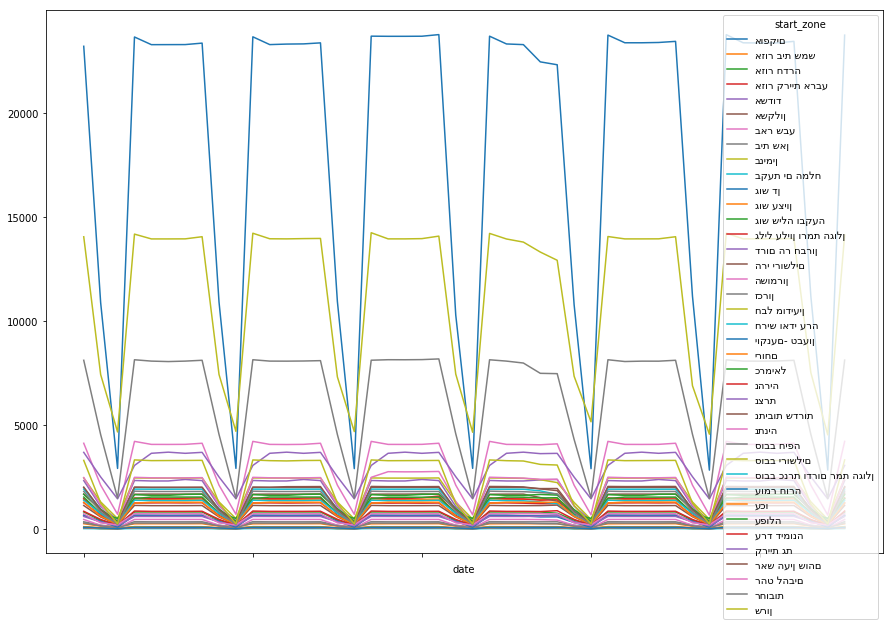

In [11]:
rs.groupby(['date', 'start_zone']).num_trips.sum().unstack().plot(figsize=(15,10))